In [4]:
# Numerical Analysis
# The comparison of cumulative discounted cost between open-loop policies and the optimal closed-loop policy (p1 = 0.1, p2 = 0.9, λ = 1.6; µ = 1, cost = 0.05)
# The simulation result is based on average cumluative discounted cost within 100s of 20 epoches, with 10 different initial state

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
lam = 0.4 #lambda
mu = 0.25 #mu
rho = 0.1 #discount factor lam+2*mu+rho=1
cost = 0.05 #technological cost
p1 = 0.1
p2 = 0.9
theta = 0.0005 #converge threshold
maxLength = 32
queue_no = 2
steps = 1000
epochs = 20
a_array=[0,0.2,0.4,0.6,0.8,1.0] #fault probability
step_size=0.1
c_0=[]
c_1=[]
c_star=[]
seed = 1

# initialization of initial state
initial_state_num = 10 # number of different initial states
random.seed(2)
initial_state = []
for i in range(0,2*initial_state_num):   
    num = random.randint(0,30)
    initial_state.append(num)

def state_to_str(state):
    return str(list(map(int,state)))

def argmin(l):
    if l[0] <= l[1]:     
        return 0
    elif l[1] < l[0]:
        return 1
    else:
        return -1

    
for a in a_array:
    # print("a = ", a)
    value = np.zeros([maxLength+1, maxLength+1])
    policy = np.zeros([maxLength+1, maxLength+1])
    while True:
        while True:
            delta = 0
            val = value.copy()
            for x in range(maxLength+1):
                for y in range(maxLength+1):
                    v = value[x][y]
                    b = policy[x][y]
                    xx = min(x+1,maxLength)
                    yy = min(y+1,maxLength)
                    if xx == x or yy == y:
                        value[x][y] = x+y+cost*b+mu*(val[max(x-1,0)][y]+val[x][max(y-1,0)])+(1-(1-b)*a)*lam*max(val[xx][y],val[x][yy])+p1*(1-b)*a*lam*val[xx][y]+p2*(1-b)*a*lam*val[x][yy]
                    else:
                        value[x][y] = x+y+cost*b+mu*(val[max(x-1,0)][y]+val[x][max(y-1,0)])+(1-(1-b)*a)*lam*min(val[xx][y],val[x][yy])+p1*(1-b)*a*lam*val[xx][y]+p2*(1-b)*a*lam*val[x][yy]
                    delta = max(delta, abs(v-value[x][y]))
            if delta<theta:
                break
        stable = True
        for x in range(maxLength+1):
            for y in range(maxLength+1):
                old = policy[x][y]
                xx = min(x+1,maxLength)
                yy = min(y+1,maxLength)
                diff = a*lam*(p1*value[xx][y]+p2*value[x][yy]-min(value[xx][y],value[x][yy]))
                if diff <= cost:
                    policy[x][y] = 0
                else:
                    policy[x][y] = 1
                if old != policy[x][y]:
                    stable = False
        if stable:
            break
    # print(policy)

    random.seed(8)
    attack_list = []
    for i in range(steps):
        attack_list.append(random.random())
        
    # Calculate total cost for beta = 0
    # print("action=0")
    c_list_more = []
    for initial_count in range(0,initial_state_num):
        c_list = []
        for k in range(epochs):
            random.seed(k)
            state = [initial_state[2*initial_count],initial_state[2*initial_count+1]] #initial state
            iteration = 0
            total_cost = 0
            stage_cost = 0
            stage_cost_discount = 0
            iter2 = 0
            iter3 = 0
            while True:
                seed_a = random.random()
                if seed_a < a:
                    fault = 1
                else:
                    fault = 0
                for i in range(queue_no):
                    seed_mu = random.random()
                    if seed_mu < mu*step_size:
                        state[i] = max(state[i]-1,0)
                action = 0
                status = fault*(1-action)
                seed_lam = random.random()
                if seed_lam < lam*step_size:
                    if status == 0:
                        j = argmin(state)
                        state[j] = state[j]+1
                    else:
                        seed_p = attack_list[iter2]
                        iter2 = iter2+1
                        if seed_p < p1:
                            state[0] = state[0]+1
                        else:
                            state[1] = state[1]+1           
                stage_cost = (sum(state) + cost * action)*step_size #C=|X|+c_b*B
                stage_cost_discount =  math.exp(-rho*iteration*step_size)*stage_cost*step_size
                total_cost += stage_cost_discount
                iteration = iteration + 1
                if iteration>=steps:
                    break
            c_list.append(total_cost)
        c_list_more.append(sum(c_list)/initial_state_num)
    # print("action = 0: ", c_list_more)
    c_0.append(sum(c_list_more)/epochs)
    
    # Calculate total cost for beta = 1
    # print("action=1")
    c_list_more = []
    for initial_count in range(0,initial_state_num):
        c_list = []
        for k in range(epochs):
            random.seed(k)
            state = [initial_state[2*initial_count],initial_state[2*initial_count+1]] #initial state
            iteration = 0
            total_cost = 0
            stage_cost = 0
            stage_cost_discount = 0
            iter2 = 0
            iter3 = 0
            while True:
                ## Sampling next state according to the probability distribution X'~p(X'|X,B)
                seed_a = random.random()
                if seed_a < a:
                    fault = 1
                else:
                    fault = 0
                for i in range(queue_no):
                    seed_mu = random.random()
                    if seed_mu < mu*step_size:
                        state[i] = max(state[i]-1,0)
                action = 1
                status = fault*(1-action)
                seed_lam = random.random()
                if seed_lam < lam*step_size:
                    j = argmin(state)    
                    state[j] = state[j]+1
                stage_cost = (sum(state) + cost * action)*step_size #C=|X|+c_b*B
                stage_cost_discount =  math.exp(-rho*iteration*step_size)*stage_cost*step_size
                total_cost += stage_cost_discount
                iteration = iteration + 1
                if iteration>=steps:
                    break
            c_list.append(total_cost)
        c_list_more.append(sum(c_list)/initial_state_num)
    # print("action = 1: ", c_list_more)
    c_1.append(sum(c_list_more)/epochs)
    
    # Calculate total cost for beta = *
    # print("action_optimal")
    c_list_more = []
    for initial_count in range(0,initial_state_num):
        c_list = []
        for k in range(epochs):
            random.seed(k)
            state = [initial_state[2*initial_count],initial_state[2*initial_count+1]] #initial state
            iteration = 0
            total_cost = 0
            stage_cost = 0
            stage_cost_discount = 0
            iter2 = 0
            while True:
                ## Sampling next state according to the probability distribution X'~p(X'|X,B)
                seed_a = random.random()
                if seed_a < a:
                    fault = 1
                else:
                    fault = 0
                for i in range(queue_no):
                    seed_mu = random.random()
                    if seed_mu < mu*step_size:
                        state[i] = max(state[i]-1,0)
                if state[0] == 33:
                    state[0] = 32
                if state[1] == 33:
                    state[1] = 32
                action = policy[state[0]][state[1]]    
                status = fault*(1-action)
                seed_lam = random.random()
                if seed_lam < lam * step_size:
                    if status == 0:
                        j = argmin(state)
                        state[j] = state[j]+1
                    else:
                        seed_p = attack_list[iter2]
                        iter2 = iter2+1
                        if seed_p < p1:
                            state[0] = state[0]+1
                        else:
                            state[1] = state[1]+1             
                stage_cost = (sum(state) + cost * action)*step_size #C=|X|+c_b*B
                stage_cost_discount = math.exp(-rho*iteration*step_size)*stage_cost*step_size
                total_cost += stage_cost_discount
                iteration = iteration + 1
                if iteration>=steps:
                    break
            c_list.append(total_cost)
        c_list_more.append(sum(c_list)/initial_state_num)
    # print("action = optimal: ", c_list_more)
    c_star.append(sum(c_list_more)/epochs)

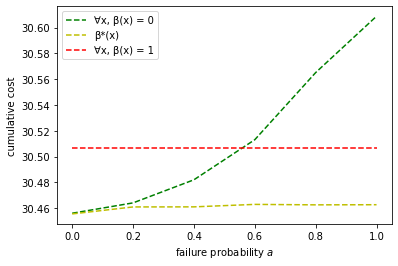

In [5]:
row = [0,0.2,0.4,0.6,0.8,1.0]
l1=plt.plot(row,c_0,'g--',label='∀x, β(x) = 0')
l2=plt.plot(row,c_star,'y--',label='β*(x)')
l3=plt.plot(row,c_1,'r--',label='∀x, β(x) = 1')
plt.xlabel('failure probability $a$')
plt.ylabel('cumulative cost')
plt.legend()